# Ptychography algorithms figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the ptychography algorithms comparison figure (Fig. 10) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter

import cmasher as cmr
cmap = cmr.bubblegum

## abTEM Simulations

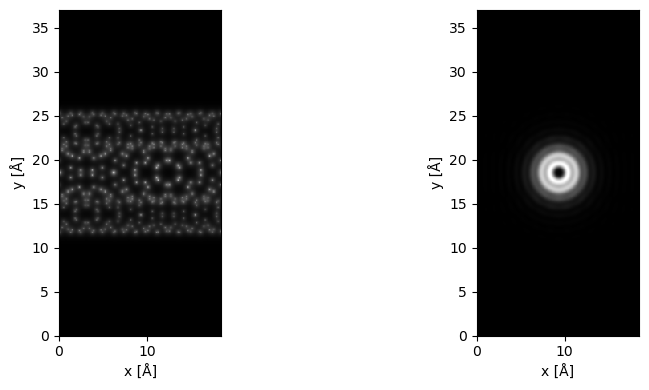

In [2]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0]/2
double_walled_cnt.center(vacuum=padding, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt_center = double_walled_cnt.cell.lengths()/2

frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

static_potential = abtem.Potential(
    #frozen_phonons,  # uncomment this for a realistic simulation     
    double_walled_cnt, # comment this for a realistic simulation
    gpts=(int(96*3*np.sqrt(2)/2),int(96*3*np.sqrt(2))),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=150,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [3]:
pixelated_detector = abtem.PixelatedDetector(max_angle=None)

grid_scan = abtem.GridScan(
    (0, static_potential.extent[1]/2-static_potential.extent[0]/2), (static_potential.extent[0],static_potential.extent[1]/2+static_potential.extent[0]/2),
    gpts=(36+1,36+1),
    endpoint=True
)

measurement = probe.scan(grid_scan, pixelated_detector, static_potential)
sx,sy,qx,qy = measurement.shape
crop_qx = (qx - 96)//2
crop_qy = (qy - 96*2)//2

array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96*2]
array = array.reshape((37,37,96,96,2)).sum(-1)

electrons_per_area = 1e6
electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)

Potential:   0%|          | 0/75 [00:00<?, ?it/s]

Scan:   0%|          | 0/1369 [00:00<?, ?it/s]

In [4]:
dc = py4DSTEM.DataCube(noisy_array)
dc.calibration.set_R_pixel_size(measurement.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement.calibrations[2].sampling)
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    2.248767617895552
             R_pixel_size:    0.515803041652313
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

## Gradient Descent

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|█| 1369/1369 [00:00<00:0


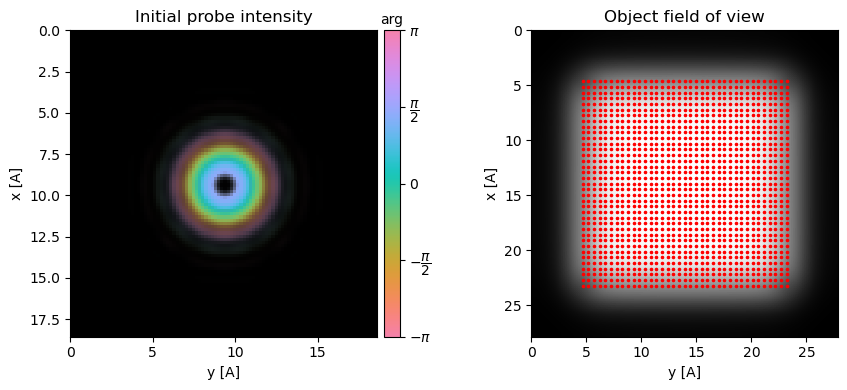

In [5]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dc,
    verbose=True,
    energy=80e3,
    semiangle_cutoff=25,
    defocus=150,
    storage='cpu',
    device='gpu',
    object_padding_px=(24,24),
).preprocess(
    force_com_rotation=0,
    force_com_transpose=False,
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 64 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.01 and step _size: 0.5.
Reconstructing object and probe: 100%|█| 64/64 [00:02


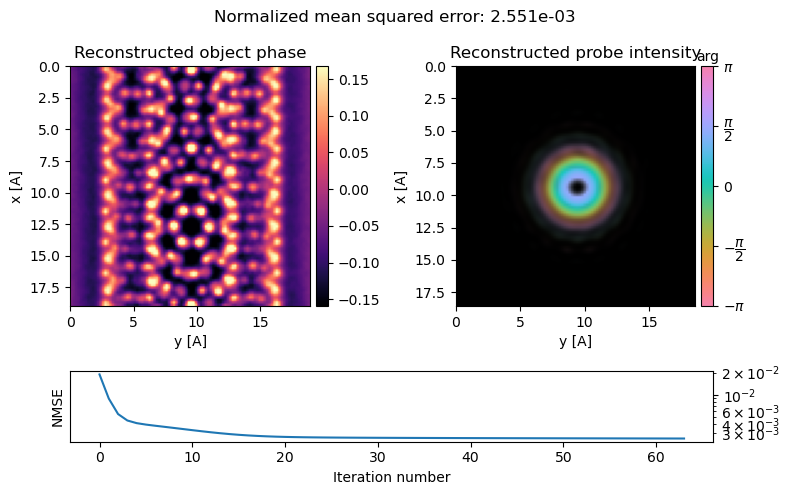

In [9]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    store_iterations=True,
    reset=True,
    normalization_min=0.01,
).visualize(
)

error_gd = ptycho.error_iterations
object_gd = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_gd.index(min(error_gd))]))

## Proximal Gradient Methods

### Alternating Projections

$$\psi^{j+1} = \mathcal{F}_c \left[\hat{P} * \hat{O}\right],$$

Performing 64 iterations using a complex object type, with the DM_AP algorithm, with normalization_min: 0.01 and α: 0.0.
Reconstructing object and probe: 100%|█| 64/64 [00:02


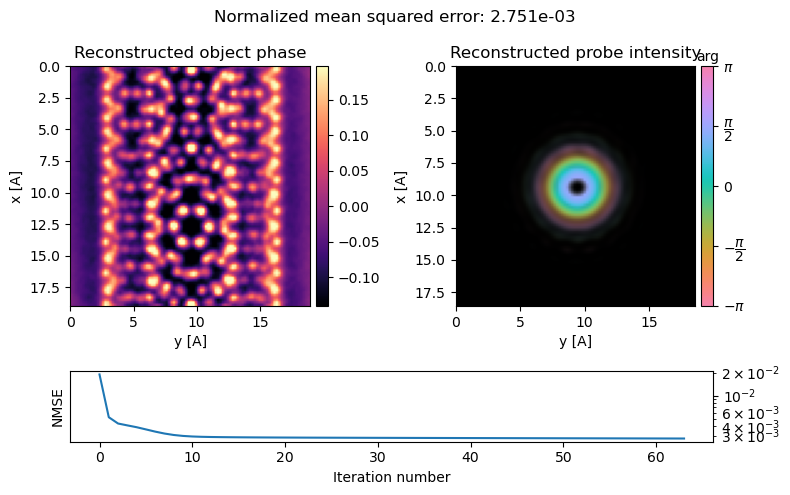

In [10]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    reconstruction_method='DM_AP',
    reconstruction_parameter=0.0,
    reset=True,
    store_iterations=True,
    normalization_min=0.01,
).visualize(
)

error_ap = ptycho.error_iterations
object_ap = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_ap.index(min(error_ap))]))

### Difference Map

$$\psi^{j+1} = \psi^j - \hat{P}*\hat{O} + \mathcal{F}_c \left[ 2 \hat{P} * \hat{O} - \psi^j \right],$$

In [11]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    reconstruction_method='DM_AP',
    reconstruction_parameter=1.0,
    reset=True,
    store_iterations=True,
    normalization_min=0.01,
)

error_dm = ptycho.error_iterations
object_dm = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_dm.index(min(error_dm))]))

Performing 64 iterations using a complex object type, with the DM_AP algorithm, with normalization_min: 0.01 and α: 1.0.
Reconstructing object and probe: 100%|█| 64/64 [00:02


### Relaxed Averaged Alternating Reflections (RAAR)

$$\psi^{j+1} = \beta \psi^j + \left(1-2\beta\right) \hat{P}*\hat{O} + \beta \mathcal{F}_c \left[ 2 \hat{P} * \hat{O} - \psi^j \right],$$

Performing 64 iterations using a complex object type, with the RAAR algorithm, with normalization_min: 0.01 and α: 0.25.
Reconstructing object and probe: 100%|█| 64/64 [00:02


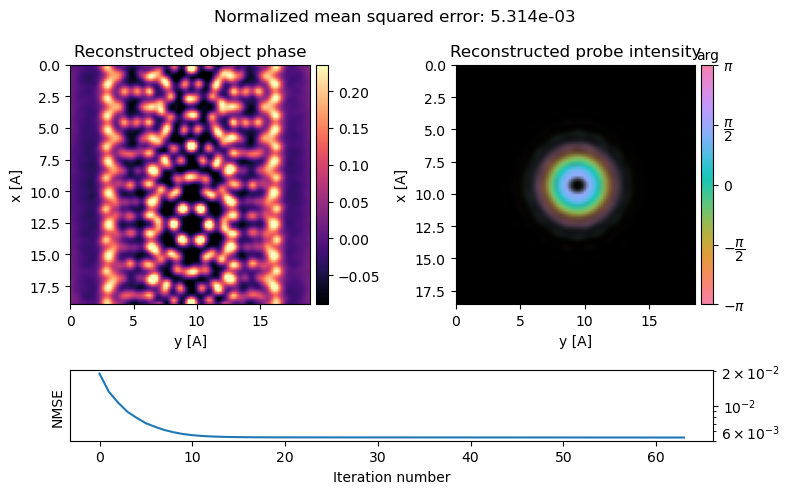

In [12]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    reconstruction_method='RAAR',
    reconstruction_parameter=0.25,
    reset=True,
    store_iterations=True,
    normalization_min=0.01,
).visualize(
)

error_raar = ptycho.error_iterations
object_raar = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_raar.index(min(error_raar))]))

### Relax-Reflect-Reflect (RRR)

$$\psi^{j+1} = \psi^j - \gamma \hat{P}*\hat{O} + \gamma \mathcal{F}_c \left[ 2 \hat{P} * \hat{O} - \psi^j \right],$$

Performing 64 iterations using a complex object type, with the RRR algorithm, with normalization_min: 0.01 and α: 0.125.
Reconstructing object and probe: 100%|█| 64/64 [00:02


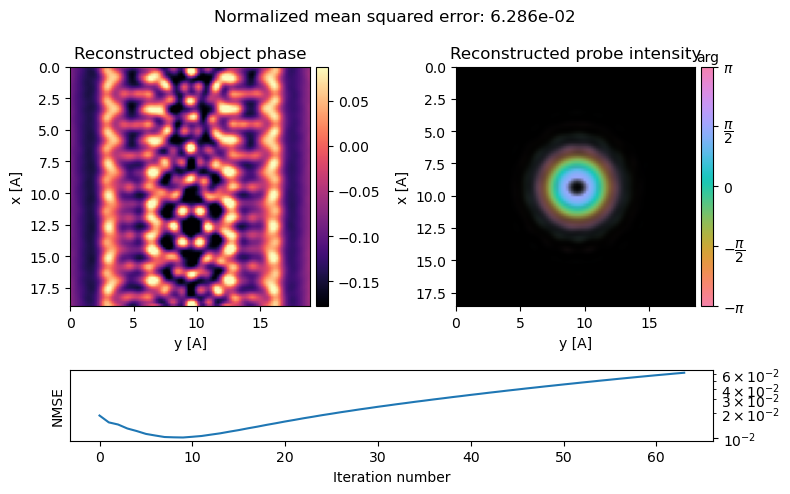

In [13]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    reconstruction_method='RRR',
    reconstruction_parameter=0.125,
    reset=True,
    store_iterations=True,
    normalization_min=0.01,
).visualize(
)

error_rrr = ptycho.error_iterations
object_rrr = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_rrr.index(min(error_rrr))]))

### Charge Flipping (SUPERFLIP)

$$\psi^{j+1} = \mathcal{F}_c \left[2 \hat{P} * \hat{O} - \psi^j \right],$$

Performing 64 iterations using a complex object type, with the SUPERFLIP algorithm, with normalization_min: 0.01 and (a,b,c): (0, 1, 2).
Reconstructing object and probe: 100%|█| 64/64 [00:02


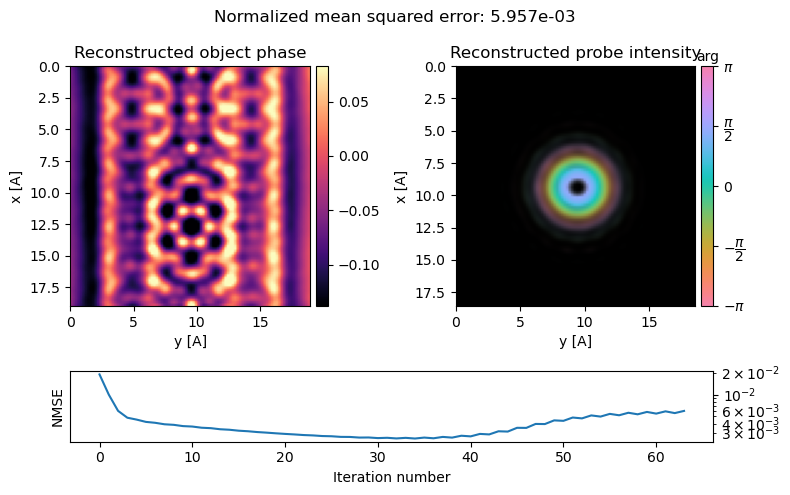

In [14]:
ptycho = ptycho.reconstruct(
    num_iter = 64,
    reconstruction_method='SUPERFLIP',
    reset=True,
    store_iterations=True,
    normalization_min=0.01,
).visualize(
)

error_flip = ptycho.error_iterations
object_flip = np.angle(ptycho._crop_rotate_object_fov(ptycho.object_iterations[error_flip.index(min(error_flip))]))

### Generalized Projection

$$\psi^{j+1} = \left(1-a-b\right) \psi^j + a \hat{P}*\hat{O} + b \mathcal{F}_c \left[ c \hat{P} * \hat{O} + \left(1-c\right) \psi^j \right],$$

In [51]:
from py4DSTEM.process.phase.parameter_optimize import OptimizationParameter, PtychographyOptimizer

init_args = {
    'datacube':dc,
    'energy':80e3,
    'semiangle_cutoff':25,
    'device':'gpu',
    'storage':'cpu',
    'clear_fft_cache':False,
    'defocus':150,
    'object_padding_px':(24,24),
}

preprocess_args = {
    'force_com_rotation': 0,
    'force_com_transpose': False,
}

recon_args = {
    'num_iter':64,
    'reconstruction_method':'generalized-projections',
    'reconstruction_parameter_a': OptimizationParameter(0,-1,2),
    'reconstruction_parameter_b': OptimizationParameter(1,-1,2),
    'reconstruction_parameter_c': OptimizationParameter(1,-1,2),
    'normalization_min':0.01,
}

Optimizing parameters: 100%|█| 100/100 [05:23<00:00, 

Optimized parameters:
reconstruction_parameter_a: 0.5055340620504132
reconstruction_parameter_b: 0.509355223949782
reconstruction_parameter_c: 0.13017113990225737


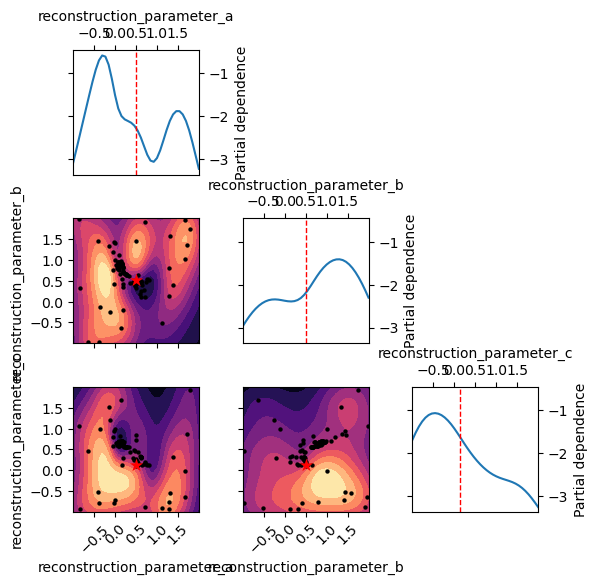

In [52]:
def error_metric(ptycho):
    converged = ptycho.error <= np.min(ptycho.error_iterations)
    rabbit_hole = ptycho.error < 1e-3
    return np.log(ptycho.error) if converged and not rabbit_hole else 0.0

optimizer = PtychographyOptimizer(
    py4DSTEM.process.phase.SingleslicePtychography,
    init_args = init_args,
    preprocess_args = preprocess_args,
    reconstruction_args = recon_args,
).optimize(
    n_calls=100,
    n_initial_points=25,
    error_metric=error_metric,
    random_state=1234
).visualize(
)

Best fit rotation forced to 0 degrees.
Transpose of intensities forced to False.
Normalizing amplitudes: 100%|█| 1369/1369 [00:00<00:0
Performing 64 iterations using a complex object type, with the generalized-projections algorithm, with normalization_min: 0.01 and (a,b,c): (0.5055340620504132, 0.509355223949782, 0.13017113990225737).
Reconstructing object and probe: 100%|█| 64/64 [00:02


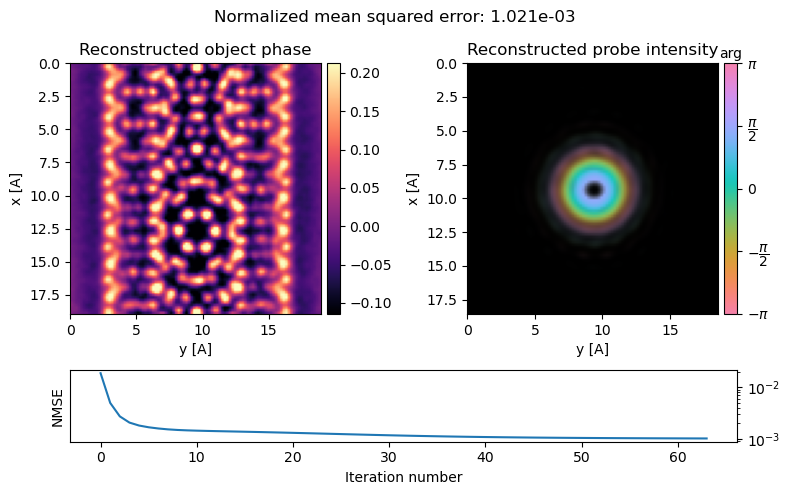

In [53]:
opt_init_args, opt_pre_args, opt_recon_args = optimizer.get_optimized_arguments()

opt_ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    **opt_init_args,
).preprocess(
    **opt_pre_args,
    plot_center_of_mass=False,
    plot_probe_overlaps=False,
).reconstruct(
    **opt_recon_args,
    store_iterations=True,
).visualize(
)

error_generalized = opt_ptycho.error_iterations
object_generalized = np.angle(opt_ptycho._crop_rotate_object_fov(opt_ptycho.object_iterations[error_generalized.index(min(error_generalized))]))

Note: Resulting figure may vary from paper.

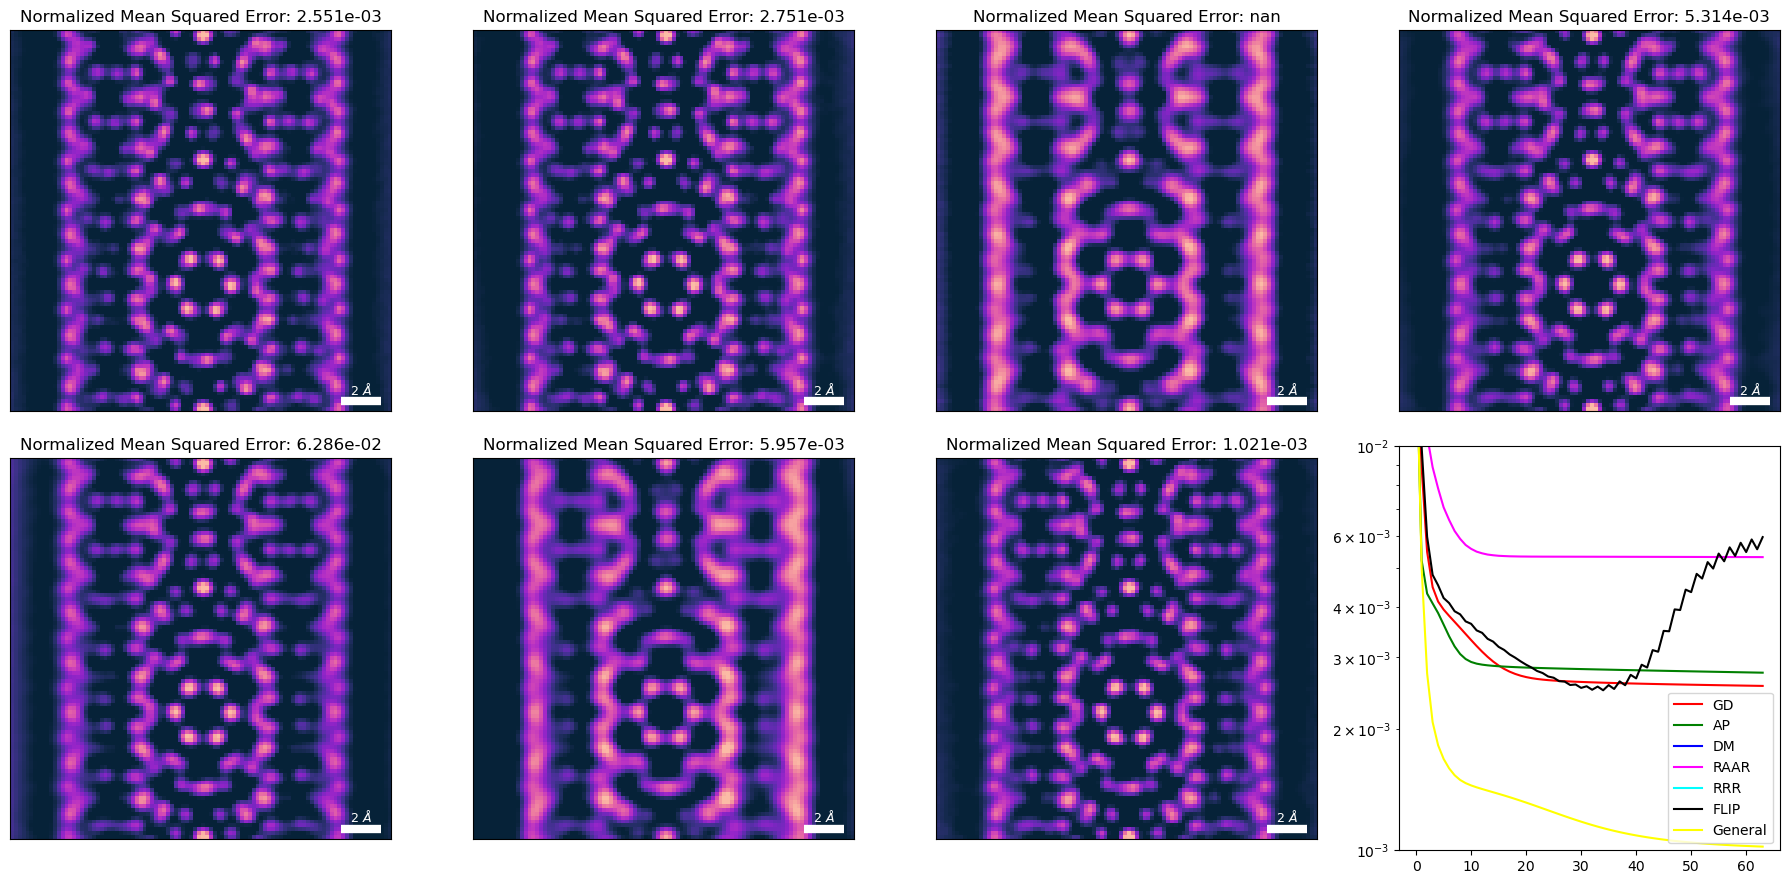

In [56]:
errors = np.vstack((
    np.array(error_gd),
    np.array(error_ap),
    np.array(error_dm),
    np.array(error_raar),
    np.array(error_rrr),
    np.array(error_flip),
    np.array(error_generalized)
)
)

objects = [
    object_gd,
    object_ap,
    object_dm,
    object_raar,
    object_rrr,
    object_flip,
    object_generalized
]

projection_fig, projection_axs = plt.subplots(2,4,figsize=(18,9))
flat_axes = projection_axs.flatten()

for index, ax in enumerate(flat_axes[:-1]):
    py4DSTEM.show(
        objects[index],
        vmin=0.333,
        vmax=0.999,
        cmap=cmap,
        ticks=False,
        scalebar=True, 
        pixelsize=ptycho.sampling[0], 
        pixelunits='$\AA$',
        title=f"Normalized Mean Squared Error: {errors[index,-1]:.3e}",
        figax=(projection_fig,ax)
    )

flat_axes[-1].set_prop_cycle(color=['red', 'green', 'blue','magenta','cyan','black','yellow'])
flat_axes[-1].semilogy(errors.T)
flat_axes[-1].legend(['GD', 'AP', 'DM', 'RAAR','RRR','FLIP','General'])
flat_axes[-1].set_ylim((1e-3, 1e-2))
projection_fig.tight_layout()

## Postprocessing
> Done in Inkscape